## Compute Max Speed for the Track Frame Database for Antarctica
---

Use a velocity map to find the max speed for each frame.

In [353]:
import geopandas as gpd
import numpy as np
import grimpfunc as grimp
import nisardev as nisar
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import warnings
import rioxarray

## Read Track Frame Data Base

In [354]:
allFrames = gpd.read_file('cryo_offsets_trackframe_database.gpkg').to_crs("epsg:3031")

## Read Velocity

This data set can be downloaded from https://nsidc.org/data/nsidc-0484/versions/2. Download and modify the path to point to the netcdf.

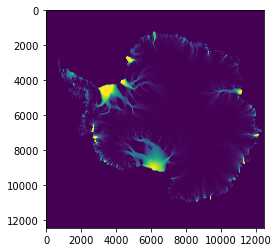

In [358]:
myPath = '/Volumes/insar11/ian/ModelingDataSets/Antarctica/MeasuresAntarctica/Phase'
urlAll = f'{myPath}/antarctica_ice_velocity_450m_v2.nc'
# Read
allMap  = rioxarray.open_rasterio(urlAll)
bboxMap = {'minx': np.min(allMap.x).item(),'miny': np.min(allMap.y).item(),
            'maxx': np.max(allMap.x).item(),'maxy': np.max(allMap.y).item()}
allMapSpeed = np.squeeze(np.sqrt(allMap.VX**2 + allMap.VY**2).rio.write_crs('epsg:3031'))
plt.imshow(allMapSpeed, vmin=1,vmax=1000)

Extract bounds for the map.

In [359]:
xbox = np.array([bboxMap[x] for x in ['minx', 'minx', 'maxx', 'maxx', 'minx']])
ybox = np.array([bboxMap[y] for y in ['miny', 'maxy', 'maxy','miny', 'miny']])
#allMap =  nisar.nisarVel() # Create Series
#allMap.readDataFromTiff(urlAll, url=False, readSpeed=False, overviewLevel=0) 
limits = Polygon(list(zip(xbox, ybox)))

In [360]:
antarcticFrames = allFrames[allFrames.intersects(limits) & allFrames['hasLand']]
len(antarcticFrames)

3539

## Create Mask for Individual Frames

This function will create a mask that includes all points in the frame.

In [281]:
def makeMaskFromPolygon(polygon, data):
    # get bounds
    ny, nx = data.shape
    x0, dx, _, y0, _, dy = [float(x) for x in data.spatial_ref.GeoTransform.split()]
    # Create empty mask
    mask = Image.new('L', (nx, ny), 0)
    # Compute frame boundary in pixel coords
    polyCoords = [( (x[1] - y0)/dy, (x[0] - x0)/dx) for x in polygon.exterior.coords]
    # Draw the mask pixels.
    ImageDraw.Draw(mask).polygon(polyCoords, outline=0, fill=1)
    # Flip and return
    return np.flipud(np.array(mask))

def limitBoxToMap(bboxFrame, bboxMap):
    bboxFrame['minx'] = max(bboxFrame['minx'], bboxMap['minx'])
    bboxFrame['miny'] = max(bboxFrame['miny'], bboxMap['miny'])
    bboxFrame['maxx'] = min(bboxFrame['maxx'], bboxMap['maxx'])
    bboxFrame['maxy'] = min(bboxFrame['maxy'], bboxMap['maxy'])
    return bboxFrame

## Find Maximum Speed

Loop through Frames and compute max speed.

......................................................................CPU times: user 25.8 s, sys: 305 ms, total: 26.1 s
Wall time: 26.1 s


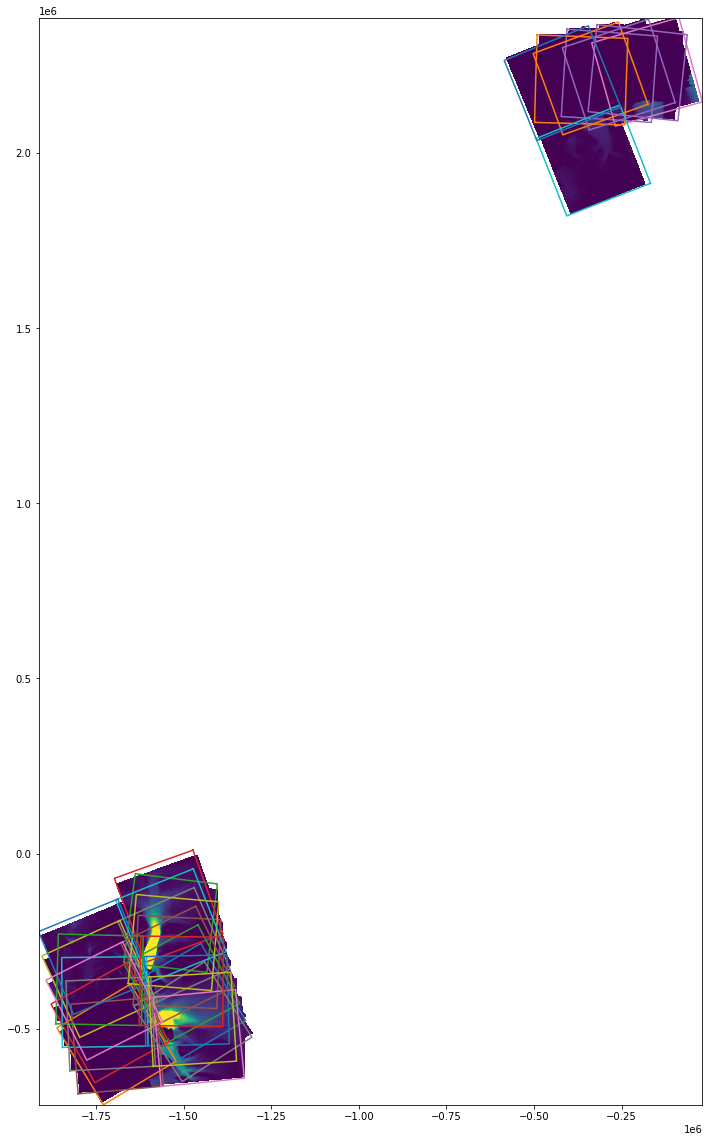

In [363]:
%%time
doPlot = True
nStop = 30e3
nProcessed = 0
frames = {}
overallMax = 5000
if doPlot:
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
with warnings.catch_warnings():  # Catch all NaN warning
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for frame in antarcticFrames.iterrows():
        bbox = dict(zip(['minx', 'miny', 'maxx', 'maxy'], frame[1]['geometry'].bounds))
        bbox = limitBoxToMap(bbox, bboxMap)
        # Crop region to bxo
        speed = np.squeeze(allMapSpeed.rio.clip_box(**bbox))
        # Create mask
        mask = makeMaskFromPolygon(frame[1]['geometry'].geoms[0], speed)
        # Eliminate spurious points that are faster than max Antarctic Speeds
        iOver = speed > overallMax
        mask[iOver.data] = 0 
        # find max speed
        maxSpeed = np.nanmax(speed * mask)
        if np.isnan(maxSpeed):
            maxSpeed = 0 
        # Save result
        frames[f'{frame[1]["track"]}-{frame[1]["frame"]}'] = maxSpeed
        #
        nProcessed += 1
        if nProcessed % 50 == 0:
            print('.', end='')
        if doPlot and maxSpeed > 4000:
            tmp = np.array(list(frame[1]['geometry'].geoms[0].exterior.coords))
            mask = mask.astype(float)
            mask[mask <= 0] = np.nan
            ax.imshow(speed * mask, extent=[bbox['minx'], bbox['maxx'], 
                                            bbox['miny'], bbox['maxy']], vmin=1, vmax=2000)
            ax.plot(tmp[:,0], tmp[:,1]);
        if nProcessed >= nStop:
            break

In [336]:
speeds = np.array(list(frames.values()))
print(max(speeds))

4468.449


## Evaluate Search Radii

Tentative set of paremters for offsets. 

In [347]:
rangeResolution  = {'20': 11.8, '40': 5.9, '80': 3.1}
azimuthResolution  = {'20': 6, '40': 6, '80': 6}
pad = 1.5  # Margin - must track speeds 1.5*max for bin. 
speedRange = {'slow': [0, 750], 'medium': [751, 2000], 'fast1': [2001, 4000], 'fast2': [4001, 6000], 'superfast': [6001, 13000]}

In [348]:
print('\t\t\t\t\tRgRadius:AzRadius (nFrames:%Frames)\n')
print('\t', end='')
for speed in speedRange:
    print(f'{speedRange[speed][0]:4}-{speedRange[speed][1]:4} (+50%)', end='\t\t')
print('')
for bw in finestResolution:
    print(f'{bw} MHz', end='\t')
    for speed in speedRange:
        searchRadiusRange = (pad*speedRange[speed][1]/365*12.)/rangeResolution[bw]
        searchRadiusAzimuth = (pad*speedRange[speed][1]/365*12.)/azimuthResolution[bw]
        nInRange = np.sum(np.logical_and(speeds >= speedRange[speed][0], speeds < speedRange[speed][1]))
        percentInRange =  nInRange/len(speeds) * 100
        print(f'{searchRadiusRange:3.0f}:{searchRadiusAzimuth:.0f}({nInRange}:{percentInRange:.1f}%) ', end='\t\t')
    print('')

					RgRadius:AzRadius (nFrames:%Frames)

	   0- 750 (+50%)		 751-2000 (+50%)		2001-4000 (+50%)		4001-6000 (+50%)		6001-13000 (+50%)		
20 MHz	  3:6(2905:82.1%) 		  8:16(497:14.0%) 		 17:33(105:3.0%) 		 25:49(31:0.9%) 		 54:107(0:0.0%) 		
40 MHz	  6:6(2905:82.1%) 		 17:16(497:14.0%) 		 33:33(105:3.0%) 		 50:49(31:0.9%) 		109:107(0:0.0%) 		
80 MHz	 12:6(2905:82.1%) 		 32:16(497:14.0%) 		 64:33(105:3.0%) 		 95:49(31:0.9%) 		207:107(0:0.0%) 		


[0, 751, 4001, 8000, 13000]


(array([2906.,  602.,   31.,    0.]),
 array([    0,   751,  4001,  8000, 13000]),
 <BarContainer object of 4 artists>)

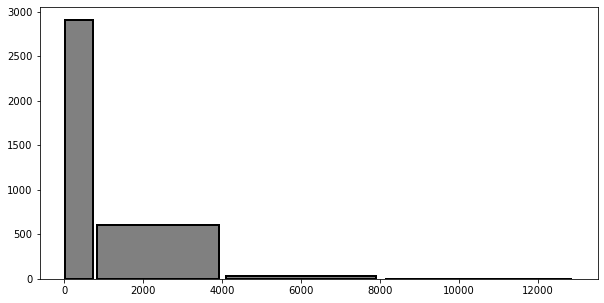

In [339]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bins = [x[0] for x in speedRange.values()]+[speedRange['superfast'][1]]
print(bins)
ax.hist(speeds,bins=bins, facecolor='gray', edgecolor='k', rwidth=.95, linewidth=2 )